# Sect 20 (v2.1): Extensions to Linear Models

- online-ds-pt-100719
- 02/27/2020


## Objectives

**DISCUSSION:**
- Discuss interactions between variables
- Discuss polynomial regressions
- Discuss the Bias vs Variance trade-off



**APPLICATION:**
- [Sect 20: Interactions Lab](https://learn.co/tracks/module-2-data-science-career-2-1/statistics-ab-testing-and-linear-regression/section-20-extensions-to-linear-models/interactions-lab)
 

- [Sect 20: Polynomial Regression Lab](https://github.com/learn-co-students/dsc-polynomial-regression-lab-online-ds-pt-100719)

## Topics Covered in Section 20


- Interactions
- Polynomial Regression    
- [Bias-Variance Trade Off](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229)

# Interactions

## What is an interaction?

When variables interact to **cause an effect** to another variable but is **not the sum of their parts**

> "An interaction is a particular property of two or more variables where they interact in a non-additive manner when affecting a third variable" - *Section recap*

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-interaction-terms-online-ds-pt-100719/master/images/new_diet_image.png">


> In our example, the interaction plot was composed out of categorical predictors (countries and diet type), but interactions can occur between categorical variables or between a mix of categorical variables and continuous variables!

### Confounding factor

>This means that the "Country" and "Diet" affect weight loss in a non-additive matter. If we're mostly interested in the effect of diet on weight loss (which seems to be plausible here), we say that "Country" is a **confounding factor** of the effect of "Diet" on weight loss.

![](images/diet_interaction.png)

### Why is important to account for interactions?

- "Not accounting for them might lead to results that are wrong."
- Replacing 2 individual columns with their interaction column can reduce the overall number of features.

- Addressing multicollinearity by creating an interaction variable instead of using the multicollinear ones.


- You'll also notice that including them when they're needed will increase your $R^2$ value!


### When should we use interactions?

- Whenever it can help the model, but not required.
- Can use in hypothesis testing as well (for ANOVAs)

## Using seaborn to view interactions

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *

fsds_1007219  v0.7.13 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


['[i] Pandas .iplot() method activated.']


In [2]:
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',0)

plt.style.use('seaborn-notebook')

In [3]:
df = fs.datasets.load_mod1_proj()




In [4]:
def scrub_df(data,drop_cols =['id','date','view'],
                       repl_dict = {'sqft_basement':('?','0.0')},
                       recast_dict = {'sqft_basement':'float'},
                       fillna_dict = {'waterfront':0,'yr_renovated':0},
                      verbose=True):
    """
    Performs scrubbing process on the df in the following order:
    1. Drop cols in the drop_cols list
    2. Replace values using repl_dict
    3. Recast dtypes using recast_dict
    4. Fillna using fillna_dict
    
    Args:
        data (Frame):
        drop_cols (list):
        repl_dict (dict): Key=column name, 
                        value= tuple/list with (current value, new value)
        recast_dict(dict):
        fillna_dict (dict):
    """
    df = data.copy()
    ## Drop cols
    if len(drop_cols)>0:
        for col in drop_cols:
            try:
                df.drop(col, axis=1,inplace=True)
            except Exception as e:
                print(f"[!] Erorr while dropping cols:")
                print(f"\t- Error msg: {e}")
        

    ## Replacing Values
    for col,replace in repl_dict.items():
        df[col] = df[col].replace(replace[0], replace[1])


    ## Recasting datatypes
    for col,dtype in recast_dict.items():
        df[col] = df[col].astype(dtype)
    df.dtypes

    
    ## Fill Null values / zeros
    for col,val in fillna_dict.items():
        import types
        if isinstance(val, types.FunctionType):
            fill_val = val(df[col])
        else:
            fill_val = val
        
        df[col].fillna(fill_val,inplace=True)
        
    if verbose:
        display(df.head())
        display(df.info())

    return df
    

In [5]:
# import types
# type(np.median)==types.FunctionType
# isinstance(np.median, types.FunctionType)

In [6]:
df = fs.datasets.load_mod1_proj()
df = scrub_df(df)#,fillna_dict={'waterfront':my_func})

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10)
memory usage: 3.0 MB


None

In [7]:
# deal with outliers
df_outs = pd.DataFrame()
for col in df.drop(columns=['price']).columns:
    idx_outs = fs.find_outliers_Z(df[col])
    df_outs[col] = idx_outs
df_outs.sum()

bedrooms          62
bathrooms        187
sqft_living      248
sqft_lot         346
floors             7
waterfront       146
condition         29
grade            130
sqft_above       253
sqft_basement    246
yr_built           0
yr_renovated     744
zipcode            0
lat                0
long             232
sqft_living15    236
sqft_lot15       363
dtype: int64

In [8]:
out_rows = df_outs.any(axis=1)
out_rows.sum(),len(df_outs)

(2200, 21597)

In [9]:
df = df[~out_rows]
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
6,257500.0,3,2.25,1715,6819,2.0,0.0,3,7,1715,0.0,1995,0.0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


### Looking for Non-linear relationships

In [24]:
## LOOKING FOR NON-LINEAR RELATIONSHIPS

from itertools import combinations,product
drop_cols = ['price','zipcode']
comb_cols = list(combinations(df.drop(drop_cols,axis=1).columns,2))

cols_v_target = list(product(df.columns,['price']))
cols_v_target

[('price', 'price'),
 ('bedrooms', 'price'),
 ('bathrooms', 'price'),
 ('sqft_living', 'price'),
 ('sqft_lot', 'price'),
 ('floors', 'price'),
 ('waterfront', 'price'),
 ('condition', 'price'),
 ('grade', 'price'),
 ('sqft_above', 'price'),
 ('sqft_basement', 'price'),
 ('yr_built', 'price'),
 ('yr_renovated', 'price'),
 ('zipcode', 'price'),
 ('lat', 'price'),
 ('long', 'price'),
 ('sqft_living15', 'price'),
 ('sqft_lot15', 'price')]

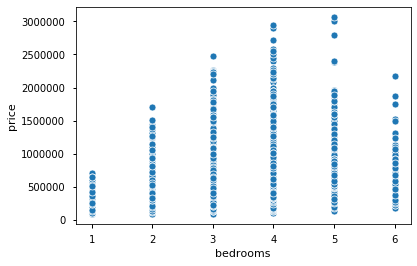

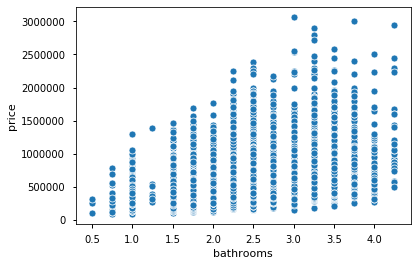

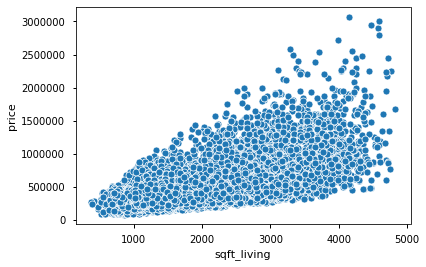

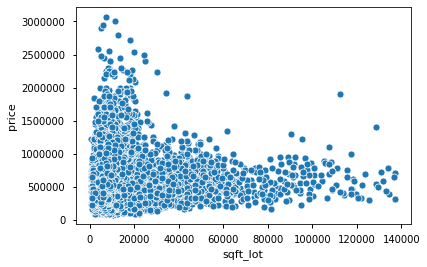

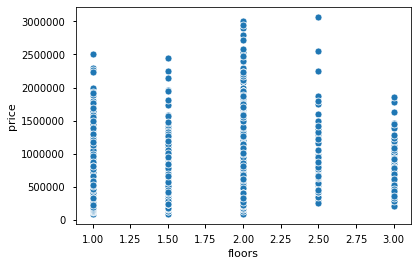

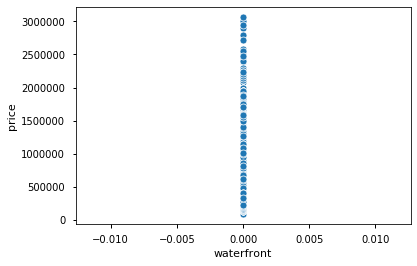

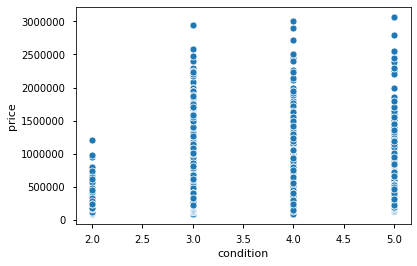

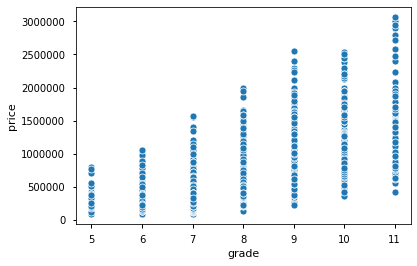

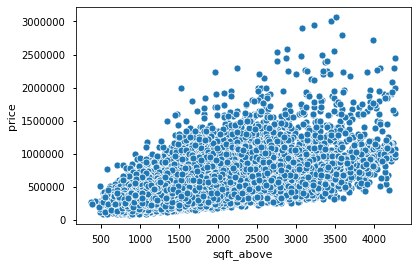

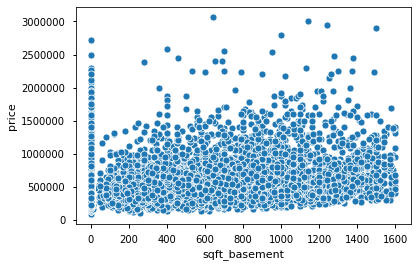

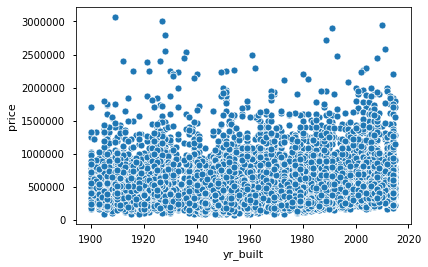

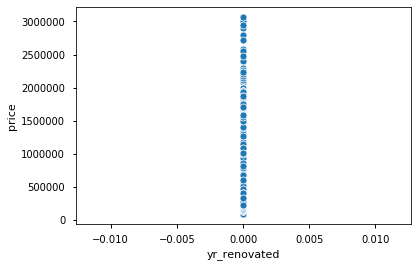

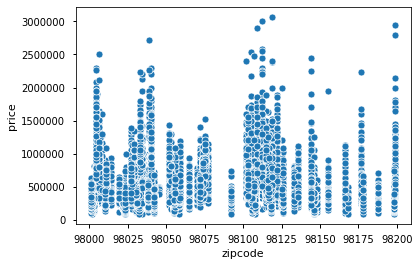

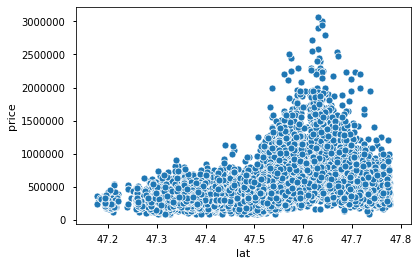

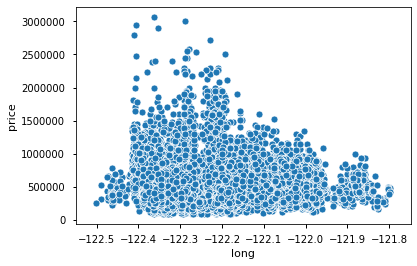

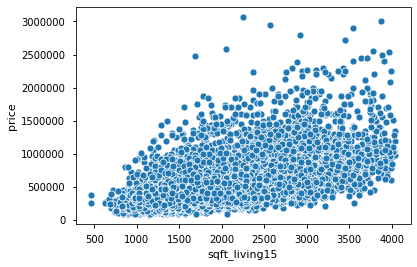

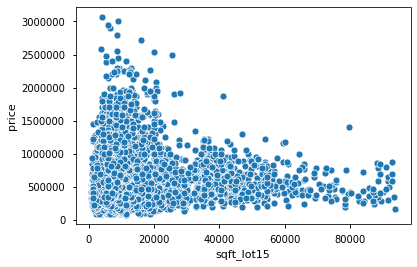

In [25]:
for (col1,col2) in cols_v_target:
    
    if col1 != col2:
        fig,ax =plt.subplots(figsize=(6,4))
        sns.scatterplot(data=df,x=col1,y=col2,ax=ax)
        plt.show()
        del fig


In [32]:
df.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [42]:
import scipy.stats as stats
import statsmodels.api as sms
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import pandas_profiling
def make_ols_f(df,target='price',cat_cols = [],
               col_list=None, show_summary=True,exclude_cols=[]):
    
    if col_list is None:
        col_list = list(df.drop(target,axis=1).columns)
        
    ## remove exclude cols
    [col_list.remove(ecol) for ecol in exclude_cols if ecol in col_list]

    features = '+'.join(col_list)


    for col in cat_cols:
        features = features.replace(col,f"C({col})")



    formula = target+'~'+features #target~predictors
    print(formula)

    model = smf.ols(formula=formula, data=df).fit()
    
    if show_summary:
        display(model.summary())

    return model

## diagnostic function

def diagnose_model(model):
    resids = model.resid
    
    fig,ax = plt.subplots(ncols=2,figsize=(10,5))
    sms.qqplot(resids, stats.distributions.norm,
              fit=True, line='45',ax=ax[0])
    xs = np.linspace(0,1,len(resids))
    ax[1].scatter(x=xs,y=resids)
    
    return fig,ax 

price~lat


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     3486.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:37:47   Log-Likelihood:            -2.6836e+05
No. Observations:               19397   AIC:                         5.367e+05
Df Residuals:                   19395   BIC:                         5.367e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.515e+07   6.04e+05    -58.217      0.000   -3.63e+07    -3.4e+07
lat         7.496e+05   1.27e+04     59.042      0.000    7.25e+05    7.75e+05
==============================================================================
Omnibus:                    10357.772   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           108883.404
Skew:                           2.362   Prob(JB):                         0.00
Kurtosis:                      13.602   Cond. No.                     1.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 576x396 with 0 Axes>

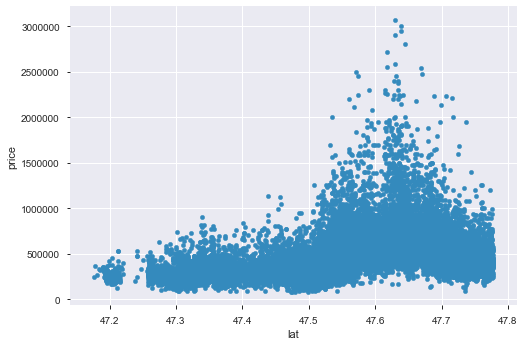

In [50]:
target = 'price'
col_list=['lat']
col=col_list[0]
exp=3

df_poly = df[[col,target]].copy()

exp_col =f"{col}_{exp}" 
df_poly[exp_col] = df_poly[col]**exp

make_ols_f(df_poly,target=target,cat_cols=[],col_list=[col])
plt.figure()
df_poly.plot(kind='scatter',x=col,y=target)
plt.show()


price~lat_3


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     3474.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:37:48   Log-Likelihood:            -2.6836e+05
No. Observations:               19397   AIC:                         5.367e+05
Df Residuals:                   19395   BIC:                         5.367e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.139e+07   2.02e+05    -56.465      0.000   -1.18e+07    -1.1e+07
lat_3        110.4556      1.874     58.940      0.000     106.782     114.129
==============================================================================
Omnibus:                    10356.318   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           108797.377
Skew:                           2.362   Prob(JB):                         0.00
Kurtosis:                      13.597   Cond. No.                     1.22e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 576x396 with 0 Axes>

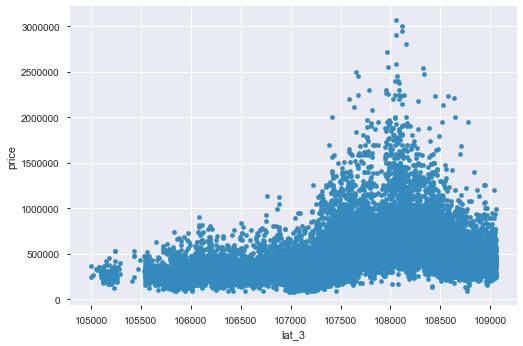

In [51]:

plt.figure()
df_poly.plot(kind='scatter',x=exp_col,y=target)
make_ols_f(df_poly,target=target,cat_cols=[],col_list=[exp_col])

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

0.15235409753196139


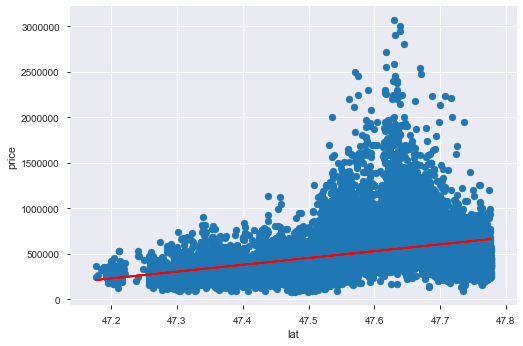

0.28577663260733965


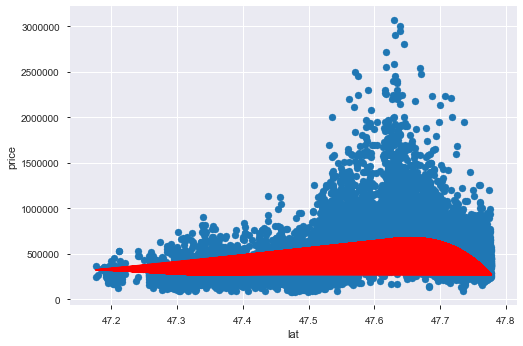

In [80]:
target = 'price'
col_list=['lat']
exp = 4
for col in col_list:
    
    y = df[target].copy()
    X = df[[col]].copy()
    
#     df_poly = pd.concat([X,y],axis=1)
    reg = LinearRegression()
    reg.fit(X,y)
    r2 =r2_score(y, reg.predict(X))
    print(r2)
    
    fig,ax = plt.subplots()
    ax.scatter(X,y)
    ax.set(xlabel=col,ylabel=target)
    ax.plot(X,reg.predict(X),color='red')
    plt.show()
    
    
    
    y = df[target].copy()
    X = df[[col]].copy()

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(exp)
    X = poly.fit_transform(X)
    reg = LinearRegression()
    
    reg.fit(X,y)
    r2 =r2_score(y, reg.predict(X))
    print(r2)
    
    fig,ax = plt.subplots()
    ax.scatter(df[[col]],y)
    ax.set(xlabel=col,ylabel=target)
    ax.plot(df[[col]],reg.predict(X),color='red')
    plt.show()
    
#     exp_col =f"{col}_{exp}" 
#     df_poly[exp_col] = df_poly[col]**exp

# #     make_ols_f(df_poly,target=target,cat_cols=[],col_list=[col])


    
#     plt.figure()
#     df_poly.plot(kind='scatter',x=exp_col,y=target)
#     make_ols_f(df_poly,target=target,cat_cols=[],col_list=[exp_col])

In [72]:
# Generate a mask for the upper triangle

def get_heatmap_mask(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)]=True
    return mask



In [ ]:
corr=df.corr()

fig, ax = plt.subplots(figsize=(20,20))
mask = get_heatmap_mask(df.corr())
sns.heatmap(df.corr(),cmap='Reds',annot=True,ax=ax,mask=mask)

In [ ]:
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr = df.drop(columns=['price']).corr()
corrtf = np.abs(corr>0.7)
s = corrtf.unstack()

sig_multi = s[s==True].reset_index()
sig_multi

In [ ]:
multi_cols = sig_multi[['level_0','level_1']].values
multi_cols

In [ ]:
for (col1,col2) in multi_cols:
    if col1 != col2:
        fig,ax = plt.subplots(ncols=3,figsize=(10,4))
        sns.regplot(data=df,x=col1,y='price',ax=ax[0])
        sns.regplot(data=df,x=col2,y='price',ax=ax[1])
        sns.scatterplot(data=df,x=col1,y=col2,ax=ax[2])
#         ax[2].set(ylim=df[col2]())
        plt.tight_layout()
        plt.show()
        del fig

In [ ]:
df_interactions = pd.DataFrame()
df_interactions['price']  =df['price'].copy()
for (col1,col2) in multi_cols:
    if col1 != col2:
        fig,ax = plt.subplots(ncols=2)
        sns.regplot(data=df,x=col1,y='price',ax=ax[0])
        sns.regplot(data=df,x=col2,y='price',ax=ax[1])

        fig, ax = plt.subplots(ncols=2,figsize=(12,4))

        df.plot(kind='scatter',x=col1,y=col2,ax=ax[0])
        ax[0].set(title=f"{col1} vs {col2}")
        
        ixn_col = f"{col1}_X_{col2}"
        df_interactions[ixn_col] = df[col1] * df[col2]
        df_interactions.plot(kind='scatter',x=ixn_col,y='price',ax=ax[1])
        ax[1].set(title=f"{ixn_col} vs 'price'")
        plt.tight_layout()
        plt.show()
        del fig
    
df_interactions.head(3)

In [ ]:
model = make_ols_f(df)
diagnose_model(model)

In [ ]:
# df = fs.datasets.load_autompg()
# # display(df.head(),df.dtypes)
# df.info()

https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6

- `sns.factorplot`
- `sns.FacetGrid`

In [ ]:
# # mpl.rcParams['figure.figsize'] = (10,6)
# # fig,ax = plt.subplots()
# ffig = sns.catplot(data=df, x='horsepower',y='mpg',
#                   hue='origin',kind='point',aspect=3,scale=0.6)
# ffig.ax.set_xticklabels(ffig.ax.get_xticklabels(),rotation=45,
#                        ha='right',size=10);

# # display(fs.get_methods_attributes_df(ffig))

In [ ]:
# ffig = sns.catplot(data=df, x='horsepower',y='mpg',
#                   col='origin',kind='point',scale=0.4)


In [ ]:
g = sns.FacetGrid(df,col='origin')
g.map(sns.distplot,"mpg")

In [ ]:
g = sns.FacetGrid(df, col='origin')
g.map(sns.regplot, "horsepower",'mpg',scatter_kws={'s':16})

In [ ]:
# sns.regplot(data=df,x='horsepower',y='mpg')#,color='origin')

# Polynomial Regressions

Remember we started with (multiple) linear equation:

$$ \large \hat{y} = w_0 + w_1  x_1 + w_2  x_2 + ... + w_N  x_N $$
$$ \large \hat{y} = \sum_{n=0}^{N} w_n x_n $$


**Knowledge check:** Why is this "linear"?

## Making it more complex!

In [ ]:
df = fs.datasets.load_yields(version='other')
display(df.head())

In [ ]:
y = df['Yield']

X = df.drop(columns=['Yield'])


plt.scatter(X, y, color='green')
plt.xlabel('Temperature')
plt.ylabel('Yield');

$\large \hat y = \hat \beta_0 + \hat \beta_1x $ 

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
plt.scatter(X, y, color='green')
plt.plot(X, reg.predict(X))
plt.xlabel('Temperature')
plt.ylabel('Yield');


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y, reg.predict(X)), r2_score(y, reg.predict(X))

### A quadratic relationship
$\large \hat y = \hat \beta_0 + \hat \beta_1x + \hat \beta_2 x^2$ 

In [ ]:
# fig,ax = plt.subplots()
# ax = df.plot(kind='scatter',x='Temp',y='Yield',sizes=[50],ax=ax)
# ax.plot(df['Temp'], reg.predict(df[['Temp']]))

In [ ]:
X['Temp_sq'] = X['Temp']**2
X.head()

In [ ]:
reg_q = LinearRegression().fit(X, y)
plt.scatter(X['Temp'], y, color='green')
plt.plot(X['Temp'], reg_q.predict(X))
plt.xlabel('Temperature')
plt.ylabel('Yield');

In [ ]:
mean_squared_error(y, reg_q.predict(X)),r2_score(y, reg_q.predict(X))

In [ ]:
xs = np.linspace(0,100)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

n_poly = 5
def get_poly_features(df,transform_col='Temp',target_col='Yield',
                     n_poly=5):
    polyfeat = PolynomialFeatures(n_poly)
    col_names = [f'{transform_col}^{i}' for i in range(n_poly+1)]

    X_poly = polyfeat.fit_transform(df[[transform_col]])
    df_poly = pd.DataFrame(X_poly,columns=col_names)
    df_poly[target_col] = df[target_col].copy()
    df_poly.dropna(inplace=True)
    return df_poly

Imagine making this (start with just one variable):

$$ \large \hat{y} = \beta_0 + \beta_1  x + \beta_2  x^2 + ... + \beta_N  x^N $$
$$ \large \hat{y} = \sum_{n=0}^{N} \beta_n x^n $$

In [ ]:
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def model_poly_data(df_poly,n_poly=5, fig_xcol='Temp^1',target_col='Yield'):

    X = df_poly.drop(columns=[target_col]).copy()
    y = df_poly[target_col].copy()
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=123)
    poly_reg = LinearRegression()#normalize=True)
    poly_reg.fit(X_train,y_train)
    
    y_hat_train =  poly_reg.predict(X_train)
    y_hat_test =  poly_reg.predict(X_test)
    
    r2_train = r2_score(y_train, y_hat_train)
    r2_test = r2_score(y_test,y_hat_test)
    
    print(f'[i] For polynomial features = {n_poly}:')
    print(f"\tTraining R2: {round(r2_train,4)}")
    print(f"\tTest R2: {round(r2_test,4)}")
    
    fig,ax = plt.subplots()
    df_poly.plot(kind='scatter',x=fig_xcol,y=target_col,sizes=[50],ax=ax)
    ax.plot(df_poly[fig_xcol], poly_reg.predict(X))
    
    plot_r2 = r2_score(y, poly_reg.predict(X))
    ax.set_title(f"Predictions From Poly={n_poly}: R2={round(plot_r2,3)}")
#     plt.scatter(X_test[fig_xcol], y_test)
#     plt.plot(X_test[fig_xcol],y_hat_test)
    return {'train_test_split': [X_train,X_test,y_train,y_test],
           'preds': {'train':y_hat_train,
                    'test':y_hat_test}}


# # def plot_poly():
#     fig,ax = plt.subplots()
#     df_poly.plot(kind='scatter',x=orig_data_col,y=target_col,sizes=[50],ax=ax)
    
#     ax.plot(df_poly[orig_data_col], preds)
    
#     ax.set_title(f"Predictions From Poly={n_poly}: R2={round(r2,3)}")
#     return fig,ax

from ipywidgets import interact

@interact
def show_poly_results(N=(1,10)):
# N =3

    df_poly = get_poly_features(df,n_poly=N,transform_col='Temp',target_col='Yield',)
#     display(df_poly.head())

    res=model_poly_data(df_poly,n_poly=N)
    # plot_poly()

In [ ]:


n_polys = [2,3,4,6,8,10]
for n in n_polys:
    kws = dict(n_poly=n)
    df_poly = get_poly_features(df,**kws)
    res = model_poly_data(df_poly,**kws)
    

In [ ]:
#     res[]
res['train_test_split']
#     model_and_plot_poly(df_poly,**kws)

![](https://github.com/learn-co-students/dsc-2-24-05-polynomial-regression-online-ds-sp-000/raw/master/index_files/index_23_0.png)

![](https://github.com/learn-co-students/dsc-2-24-05-polynomial-regression-online-ds-sp-000/raw/master/index_files/index_28_0.png)

For more general (multiple variables):

$$ \large \hat{y} = \beta_{0,0} + \sum_{i=0}^{N} \beta_{1,i} x_1^i + \sum_{i=0}^{N} \beta_{2,i} x_2^i + ... + \sum_{i=0}^{N} \beta_{M,i} x_M^i$$ 

$$ \large \hat{y} = \sum_{i=0}^{N}\sum_{j=0}^{M} \beta_{j,i} x_j^i $$ 


# Bias-Variance Trade Off

## Underfitting and Overfitting

Let's formalize this:


> *Underfitting* happens when a model cannot learn the training data, nor can it generalize to new data.

The simple linear regression model fitted earlier was an underfit model.

> *Overfitting* happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data 

## The Bias-Variance Trade Off


Another perspective on this problem of overfitting versus underfitting is the bias-variance tradeoff. 

We can break down our error term (the mean squared error) as the sum of 3 sources of error: 

- *bias*
- *variance*, and
- *irreducible error* 

 

$$ \large \text{MSE} = \text{Bias}(\hat{f}(x))^2 + \text{Var}(\hat{f}(x)) + \sigma^2$$
- The derivation of this can be found [here](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation).

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-bias-variance-trade-off-online-ds-pt-100719/master/images/new_bias_variance.png">


- **Bias** arises when wrong assumptions are made when training a model. For example:

    - An interaction effect is missed, 
    - We missed a certain polynomial relationship. 
    
    - Because of this, our algorithm misses the relevant relations between predictors and the target variable.
    - *(Note how this is similar to underfitting!)*


- **Variance** arises  when a model is too sensitive to small fluctuations in the training set. 

    - When variance is high, random noise is modeled instead of the intended outputs. 
    - *(This is overfitting!)*

<img src="https://raw.githubusercontent.com/jirvingphd/fsds_pt_100719_cohort_notes/master/Images/bias_variance_optimize.png">


> **The balance between bias and variance is a trade-off.** We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. 
- Bias is usually associated with low model complexity, variance with high model complexity.
- There is generally a "sweet spot" in-between, compromising between bias and variance.


